# Imports

In [1]:
import os
import json
import pickle
import tarfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

import seaborn as sns

from utils import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Define Helper Functions

In [3]:
# define a function to save the feature vector dictionary to disk
def load_feature_data(vectors_filepath, names_filepath):
    
    # extract the JSON file from the tar.gz file
    with tarfile.open(vectors_filepath, 'r:gz') as tar:
        tar.extractall()
        json_filename = tar.getnames()[0]  # assuming only one file in the archive
    
    # load the JSON file and convert Python lists back to numpy arrays
    with open(json_filename, 'r') as f:
        feature_vectors_dict = json.load(f)
    
    feature_vectors = {}
    for class_name, vectors in feature_vectors_dict.items():
        feature_vectors[class_name] = [np.array(vector) for vector in vectors]
    
    # remove the extracted JSON file
    os.remove(json_filename)
    
    # load feature names
    with open(names_filepath, 'rb') as f:
        feature_names = pickle.load(f)
        
    return feature_vectors, feature_names

In [4]:
# define a function to apply transformations prior to modeling
def preprocess_data(feature_vectors, scaler, pca_model):
    X = []
    y = []
    
    for class_name, vectors in feature_vectors.items():
        for vector in vectors:
            X.append(vector)
            y.append(class_name)
    
    # z-standardization
    X_scaled = scaler.transform(X)
    
    # PCA transformation
    X_pca = pca_model.transform(X_scaled)
    
    return X_pca, np.array(y)

In [5]:
# define a function to train data on RFC and SVM using grid search
def train_models(X_train, y_train):
    # Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42)
    # specify model parameters to analyze
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20]
    }
    rf_grid_search = GridSearchCV(rf_classifier, rf_params, cv=5, scoring='accuracy')
    rf_grid_search.fit(X_train, y_train)
    print("Best parameters for Random Forest Classifier:", rf_grid_search.best_params_)
    
    # Support Vector Machine
    svc_classifier = SVC(random_state=42)
    # specify model parameters to analyze
    svc_params = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
    svc_grid_search = GridSearchCV(svc_classifier, svc_params, cv=5, scoring='accuracy')
    svc_grid_search.fit(X_train, y_train)
    print("Best parameters for Support Vector Machine:", svc_grid_search.best_params_)
    
    return rf_grid_search, svc_grid_search

In [6]:
# define a function to evaluate the trained model on the training and validation sets
def evaluate_models(model, X_train, y_train, X_val, y_val):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    train_accuracy = accuracy_score(y_train, train_preds)
    val_accuracy = accuracy_score(y_val, val_preds)
    
    print("Train Accuracy:", train_accuracy)
    print("Validation Accuracy:", val_accuracy)
    
    return train_preds, val_preds

In [7]:
# define a function to visualize the confusion matrices
def plot_confusion_matrix(y_true, y_pred, classes, title):
    # compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # plot the confusion matrix
    plt.figure(figsize=(10, 7))
    # plot the confusion matrix as an image with blue colors
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    # define the tick marks for the classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # add text annotations for each cell
    fmt = 'd'
    # set a 50% threshold to improve text coloration
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Load data

In [8]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']

In [9]:
# load feature data from disk
feature_vectors_train, feature_names = load_feature_data("../data/processed/feature_vectors_train.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_val, feature_names = load_feature_data("../data/processed/feature_vectors_val.tar.gz", "../data/processed/feature_names.pkl")
feature_vectors_test, feature_names = load_feature_data("../data/processed/feature_vectors_test.tar.gz", "../data/processed/feature_names.pkl")

In [10]:
# load z-standardization scaler
with open("../data/processed/features_scaler.pkl", 'rb') as f:
    features_scaler = pickle.load(f)

# load pca model
with open("../data/processed/pca_model.pkl", 'rb') as f:
    pca_model = pickle.load(f)

# Transform data

In [11]:
# preprocess data
X_train, y_train = preprocess_data(feature_vectors_train, features_scaler, pca_model)
X_val, y_val = preprocess_data(feature_vectors_val, features_scaler, pca_model)

# Model data

In [12]:
# train models
rf_model, svc_model = train_models(X_train, y_train)

Best parameters for Random Forest Classifier: {'max_depth': 20, 'n_estimators': 300}
Best parameters for Support Vector Machine: {'C': 10, 'kernel': 'rbf'}


In [13]:
# evaluate models

print("Random Forest Classifier:")
train_preds_rf, val_preds_rf = evaluate_models(rf_model, X_train, y_train, X_val, y_val)

print("\nSupport Vector Machine:")
train_preds_svc, val_preds_svc = evaluate_models(svc_model, X_train, y_train, X_val, y_val)

Random Forest Classifier:
Train Accuracy: 1.0
Validation Accuracy: 0.9424640400250156

Support Vector Machine:
Train Accuracy: 1.0
Validation Accuracy: 0.9893683552220137


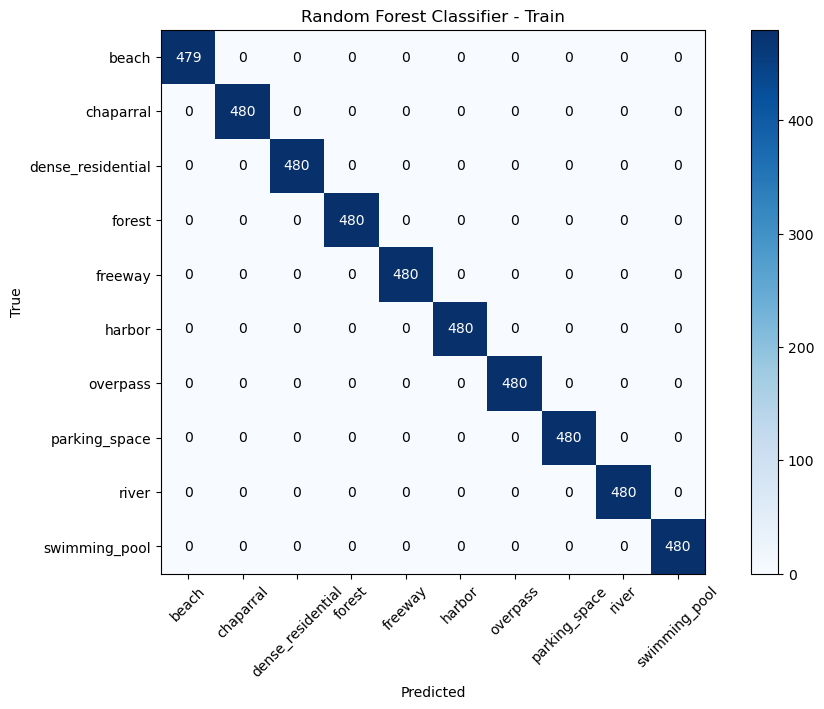

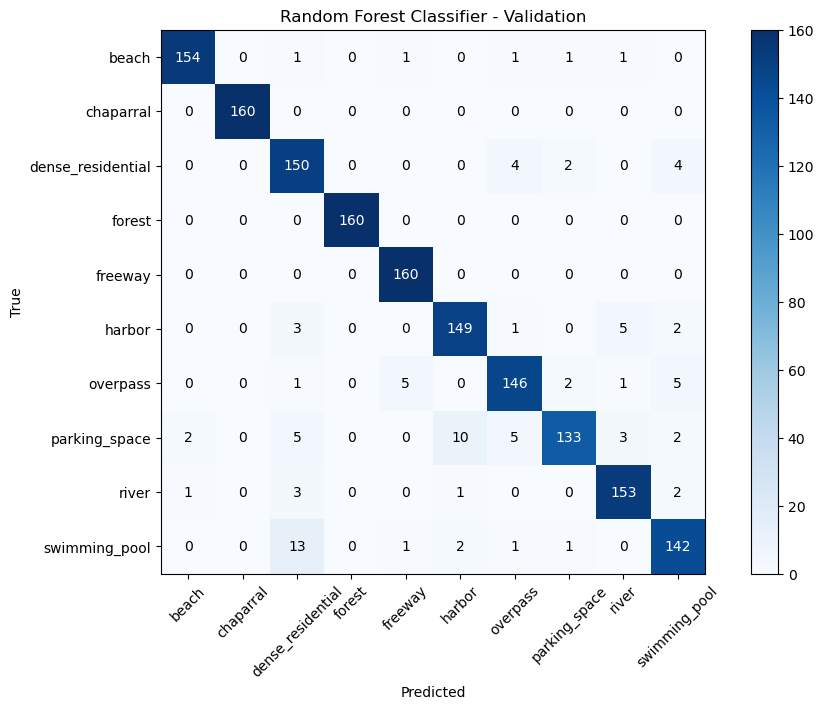

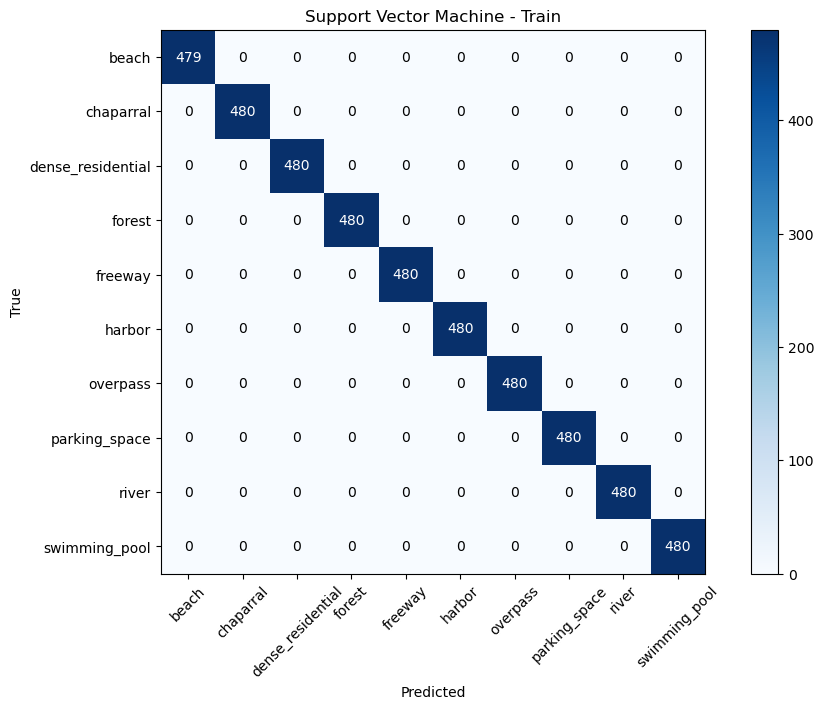

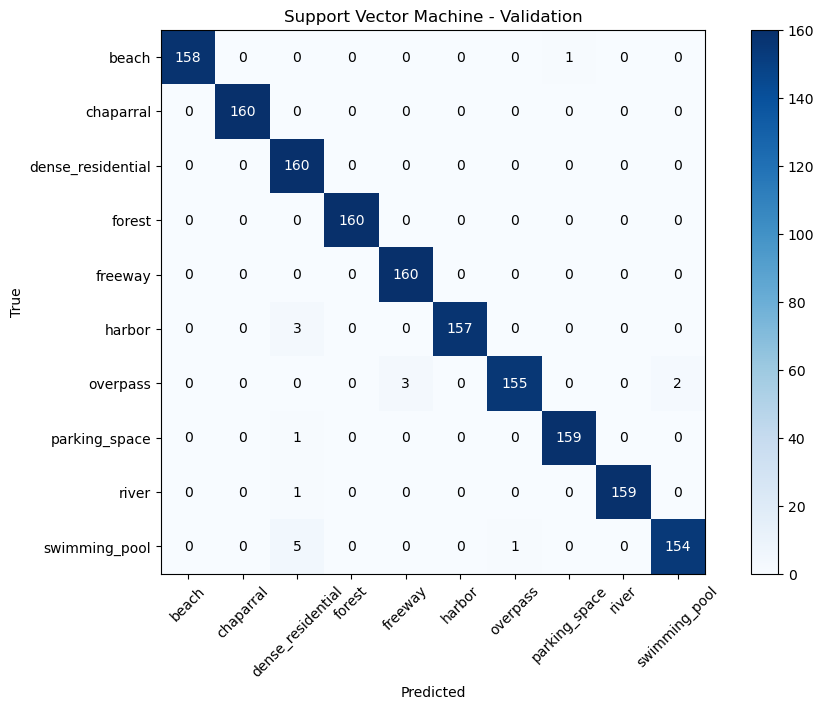

In [14]:
# plot confusion matrices

plot_confusion_matrix(y_train, train_preds_rf, classes, title='Random Forest Classifier - Train')
plot_confusion_matrix(y_val, val_preds_rf, classes, title='Random Forest Classifier - Validation')

plot_confusion_matrix(y_train, train_preds_svc, classes, title='Support Vector Machine - Train')
plot_confusion_matrix(y_val, val_preds_svc, classes, title='Support Vector Machine - Validation')